# Explore here

In [6]:
import pandas as pd
import numpy as np
from scipy import stats
#import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree


from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier


from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from tableone import TableOne, load_dataset
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc

In [7]:
ls

__pycache__/  app.py  explore.ipynb  templates/  utils.py


In [8]:
df = pd.read_csv('../data/train (3).csv')

In [9]:
df.head(3)

,index,Ganancia bruta,Ganancia (pérdida),Ingresos de actividades ordinarias,Costo de ventas,Patrimonio total,Total pasivos,Total de activos,Ganancias acumuladas,Pasivos corrientes totales,Activos corrientes totales,Sector,event
0,7620,3.218247e+05,1322028.0,3.218247e+05,NaN,9.147743e+06,97298.0,9.245041e+06,2610498.0,97298.0,3207644.0,L,0.0
1,17602,1.665600e+05,-160393.0,1.665600e+05,NaN,3.594330e+05,64899.0,4.243320e+05,-160393.0,64899.0,193787.0,G,0.0
2,18421,2.387397e+06,380574.0,3.686907e+06,1299510.0,2.421259e+06,2945965.0,5.367224e+06,461980.0,1615549.0,3364490.0,J,0.0


In [10]:
def is_binary(df_, nums):
    df = df_.copy()
    variables = []
    for var in nums:
        flag = True
        unique = df_[var].unique()
        for value in unique:
            if value not in [0, 1, np.nan, 0.0, 1.0]:
                flag = False
        if flag == True:
            variables.append(var)
    return variables

def breakdown_vars(df, off_binary=False):
    """
    This function allow us categorize accodign to numerical or not
    """
    binaries = is_binary(df, df.columns)
    categorial = []
    nonormal = []
    normal = []
    for t in df.columns:
        if off_binary == False:
          if (df[t].dtypes.name=="object" or df[t].dtypes.name=='category') and  t not in binaries:
            categorial.append(t)
        else:
           if (df[t].dtypes.name=="object" or df[t].dtypes.name=='category'):
            categorial.append(t)
        if (df[t].dtypes=="int64" or df[t].dtypes=="float64") and t not in binaries:
                n,p = stats.shapiro(df[t])
                if p<0.05:
                    nonormal.append(t)
                else:
                    normal.append(t)
    if off_binary == False:
      return categorial, binaries, nonormal, normal
    else:
      return categorial, nonormal, normal

def normalize(array):
  return (array - array.mean())/array.std()


def clean(df):
    # tener en cuenta...
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

In [11]:
#factorizar
df['Sector'] = pd.factorize(df['Sector'])[0]

#drop
df = df.drop(columns=['Costo de ventas']) #muchos Nan

#input Nan
df['Ganancias acumuladas'] = df['Ganancias acumuladas'].fillna(df['Ganancias acumuladas'].mean())
df['Pasivos corrientes totales'] = df['Pasivos corrientes totales'].fillna(df['Pasivos corrientes totales'].mean())
df['Activos corrientes totales'] = df['Activos corrientes totales'].fillna(df['Activos corrientes totales'].mean())

#ratios
df['ROA']=df['Ganancia (pérdida)']/df['Total de activos']
df['ROE']=df['Ganancia (pérdida)']/df['Patrimonio total']
df['DR']=df['Total pasivos']/df['Total de activos']
df['DC']=df['Pasivos corrientes totales']/df['Total pasivos']
df['WCR']=df['Activos corrientes totales']/df['Pasivos corrientes totales']

##df['LTD/E']=df['Total pasivos']/df['Patrimonio total']
##df['RP'] = df['Ganancia bruta'] / df['Patrimonio total']
##df['Ax1'] = (df['Activos corrientes totales'] - df['Pasivos corrientes totales'])/df['Total de activos']
##df['Ax2'] = (df['Ganancias acumuladas'] / df['Total de activos'])
##df['SRA'] = df['Pasivos corrientes totales'] / df['Patrimonio total']         ...ratios que generan colinealidad


#datos
features = ['Sector', 'ROA', 'ROE', 'DR', 'DC', 'WCR', 'event']
df = df[features]

#limpiar
df = clean(df)
df = df.dropna()

In [12]:
df.head(3)

,Sector,ROA,ROE,DR,DC,WCR,event
0,0.0,0.142999,0.144520,0.010524,1.000000,32.967214,0.0
1,1.0,-0.377989,-0.446239,0.152944,1.000000,2.985978,0.0
2,2.0,0.070907,0.157180,0.548881,0.548394,2.082568,0.0


In [13]:
#tabla1
cat, binaries, nonormal, normal = breakdown_vars(df, off_binary=False)
mytable = TableOne(df,categorical=cat, nonnormal=nonormal, groupby='event', pval=True)
mytable

/home/vscode/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 14059.
  res = hypotest_fun_out(*samples, **kwds)


Grouped by event                                                       
                                 Missing        Overall            0.0              1.0 P-Value
n                                                 14059          13814              245        
Sector, median [Q1,Q3]                 0  5.0 [1.0,6.0]  5.0 [1.0,6.0]    6.0 [1.0,6.0]  <0.001
ROA, median [Q1,Q3]                    0  0.0 [0.0,0.1]  0.0 [0.0,0.1]  -0.0 [-0.1,0.0]  <0.001
ROE, median [Q1,Q3]                    0  0.1 [0.0,0.2]  0.1 [0.0,0.2]   0.0 [-0.1,0.1]  <0.001
DR, median [Q1,Q3]                     0  0.5 [0.3,0.7]  0.5 [0.3,0.7]    0.7 [0.6,0.9]  <0.001
DC, median [Q1,Q3]                     0  0.7 [0.4,1.0]  0.8 [0.4,1.0]    0.5 [0.2,0.9]  <0.001
WCR, median [Q1,Q3]                    0  1.7 [1.1,3.3]  1.7 [1.1,3.3]    1.3 [0.8,2.4]  <0.001

<Axes: >

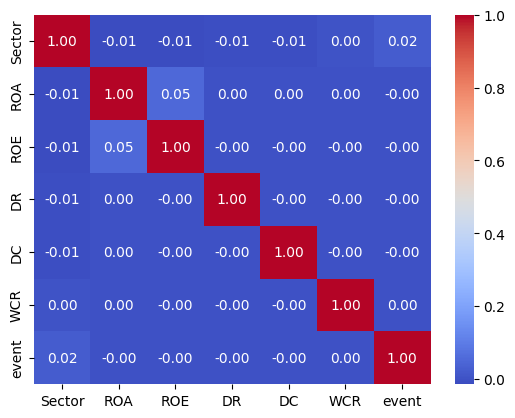

In [14]:
#correlacion
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f") #no hay

In [15]:
#target
X = df.drop('event', axis=1)
y = df['event']

In [16]:
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state = 666, stratify=y)

In [17]:
#desbalanceo
rus = RandomUnderSampler(random_state=1234)
X_train, y_train = rus.fit_resample(X, y)

In [18]:
model_rf = RandomForestClassifier(random_state = 42)
model_rf.fit(X_train, y_train)
preds_rf = model_rf.predict(X_test)
print(classification_report(y_test, preds_rf))

#roc
fpr, tpr, thresholds = roc_curve(y_test, preds_rf)
roc_auc = auc(fpr, tpr)
print(roc_auc)

              precision    recall  f1-score   support

         0.0       1.00      0.74      0.85      2763
         1.0       0.06      1.00      0.12        49

    accuracy                           0.75      2812
   macro avg       0.53      0.87      0.49      2812
weighted avg       0.98      0.75      0.84      2812

0.8715164676076728


In [19]:
def grid_RandomForest(X_train, y_train):
  model = RandomForestClassifier(random_state=0)
  n_estimators = [100,500]
  criterion = ['gini', 'entropy', 'log_loss']
  min_samples_split = [0.05, 0.1,]
  max_depth = [2,3,4]
  grid = dict(n_estimators = n_estimators, criterion = criterion,
              min_samples_split = min_samples_split, max_depth = max_depth)
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
  grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv,
                            scoring='recall',error_score='raise')
  grid_result = grid_search.fit(X_train, y_train)
  return  grid_result.best_estimator_

In [20]:
best_rf = grid_RandomForest(X_train,y_train)
best_rf.fit(X_train, y_train)
preds_rf2 = best_rf.predict(X_test)
print(classification_report(y_test, preds_rf2))

#roc
fpr, tpr, thresholds = roc_curve(y_test, preds_rf2)
roc_auc = auc(fpr, tpr)
print(roc_auc)

/home/vscode/.local/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


              precision    recall  f1-score   support

         0.0       0.99      0.72      0.84      2763
         1.0       0.05      0.78      0.09        49

    accuracy                           0.72      2812
   macro avg       0.52      0.75      0.46      2812
weighted avg       0.98      0.72      0.82      2812

0.749499582677805


In [39]:
from joblib import dump

In [ ]:
#dump(best_rf, open("../models/best_rf", "wb"))

In [65]:
import joblib
model = joblib.dump(best_rf, '../models/best_rf.pkl')